In [19]:
%load_ext autoreload
%autoreload 2

import cesium
import numpy as np
import scipy
import pandas as pd
import warnings
import tarfile
import os
import time
import shutil
import joblib
from collections import defaultdict
from random import shuffle
import matplotlib.pyplot as plt
from supersmoother import SuperSmoother
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from cesium.data_management import parse_and_store_ts_data
from cesium.features import GENERAL_FEATS, LOMB_SCARGLE_FEATS, CADENCE_FEATS
from cesium import featurize

import seaborn as sns; sns.set()
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Parse and store TS data
def parse_ts_data_return_paths(tarball_path, header_path=None):
    # header_path = 'data/survey_lcs.header.dat'

    try:
        shutil.rmtree('/tmp/noisification_ts_data')
    except FileNotFoundError:
        pass
    os.mkdir('/tmp/noisification_ts_data')

    start_time = time.time()

    ts_paths = parse_and_store_ts_data(
        data_path=tarball_path, output_dir='/tmp/noisification_ts_data',
        cleanup_archive=False, header_path=header_path, cleanup_header=False)

    print('Parsed & stored', len(ts_paths), 'light curves in', 
          '{} minutes'.format(round((time.time() - start_time)/60, 2)))
    
    return ts_paths

In [3]:
# Generate features (just frequencies here)
def generate_features(ts_paths):
    start_time = time.time()

    featureset, labels = featurize.featurize_ts_files(
        ts_paths, features_to_use=['freq1_freq'],
        output_path=None)

    print("Featurized {} light curves in {} minutes.".format(len(ts_paths),
                                                             round((time.time() - start_time)/60., 2)))
    return featureset

In [4]:
def plot_data_4x4(t, m, e, period, target_t, noisified_m, target_e, plot_title=None):
    fig, ax = plt.subplots(2, 2)
    fig.subplots_adjust(hspace=0.25)
    fig.suptitle(plot_title, fontsize=14, fontweight='bold')

    # Original ASAS LC
    t_folded = t % period

    # Plot original ASAS data
    ax[0][0].errorbar(t, m, e, fmt='.')
    ax[0][0].set_xlabel('t')
    ax[0][0].set_title('Original ASAS LC')

    # Plot period-folded ASAS data
    ax[1][0].errorbar(t_folded, m, e, fmt='.')
    ax[1][0].set_xlabel('t')
    ax[1][0].set_title('Original ASAS LC - Period-folded')

    # Generate smoothed curves for the above
    t_smooth = np.linspace(np.min(t), np.max(t), 1000)
    t_smooth_folded = np.linspace(0, period, 1000)
    m_fit = SuperSmoother(period=period).fit(t, m, e).predict(t_smooth)
    m_fit_folded = SuperSmoother(period=period).fit(t_folded, m, e).predict(t_smooth_folded)

    # Plot smoothed curves over ASAS data
    ax[0][0].plot(t_smooth, m_fit, '-k', lw=1)
    ax[1][0].plot(t_smooth_folded, m_fit_folded, '-k', lw=1)

    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    # Target survey LC
    target_t_folded = target_t % period

    # Plot noisified target survey LC data
    print('target_t head and tail:', target_t[:3], target_t[-3:])
    ax[0][1].errorbar(target_t, noisified_m, target_e, fmt='.')
    ax[0][1].set_xlabel('t')
    ax[0][1].set_title('LC noisified to target survey')

    # Plot period-folded target survey LC data
    ax[1][1].errorbar(target_t_folded, noisified_m, target_e, fmt='.')
    ax[1][1].set_xlabel('t')
    ax[1][1].set_title('LC noisified to target survey - Period-folded')

    # Generate smoothed curves for the above
    t_smooth = np.linspace(np.min(target_t), np.max(target_t), 1000)
    t_smooth_folded = np.linspace(0, period, 1000)
    m_fit = SuperSmoother(period=period).fit(target_t, noisified_m, target_e).predict(t_smooth)
    m_fit_folded = SuperSmoother(period=period).fit(target_t_folded, noisified_m, target_e).predict(t_smooth_folded)

    # Plot smoothed curves over target survey LC data
    ax[0][1].plot(t_smooth, m_fit, '-k', lw=1)
    ax[1][1].plot(t_smooth_folded, m_fit_folded, '-k', lw=1)
            
    return ax

In [5]:
def noisify_light_curve(t, f, e, period, target_t, target_f, target_e, plot_title=None):
    t = np.array(t)
    f = np.array(f)
    e = np.array(e)
    
    # First clean up by removing points with e >= 3 * sigma_e
    indices_to_remove = []
    for idx, err_el in enumerate(target_e):
        if np.abs(err_el - np.mean(target_e)) / np.std(target_e) >= 3.0:
            indices_to_remove.append(idx)
    target_t = np.delete(target_t, indices_to_remove)
    target_f = np.delete(target_f, indices_to_remove)
    target_e = np.delete(target_e, indices_to_remove)
    
    # Convert mags to fluxes if relevant
    if np.mean(target_f) > 35.0: # fluxes, not mags
        scaled_f = 10**(-f / 2.5)
        scaled_e = 10**(-e / 2.5)
    
        # Scale f & e to match target LC
        scaled_f *= np.mean(target_f) / np.mean(scaled_f)
        scaled_e *= np.mean(target_f) / np.mean(scaled_f)
    else:
        scaled_f = f + np.mean(target_f) - np.mean(f)
        scaled_e = e
    
    # Create and fit model
    model = SuperSmoother(period=period)
    fit_f = model.fit(t, scaled_f, scaled_e).predict(target_t)
    noise = [np.random.normal(0, np.abs(e) if e else 0.1) 
             for e in target_e]
    noisified_f = fit_f + noise
    
    if plot_title:
        plot_data_4x4(t, f, e, period, target_t, noisified_f, target_e, plot_title=plot_title)
    
    return target_t, noisified_f, target_e

In [6]:
def generate_survey_to_fpaths_dict(header_path, ts_data_dir):
    df = pd.read_csv(header_path)
    d = {survey: [os.path.join(ts_data_dir, '{}.npz'.format(os.path.splitext(fname)[0])) 
                  for fname in group['filename'].tolist()]
         for survey, group in df.groupby('target')}
    return d

# Specify paths

In [7]:
asas_tarball_path = os.path.abspath(os.path.join('..', '..', 'survey_classifier_data', 
                                                 'data', 'asas_training_set.tar.gz'))
asas_header_path = os.path.abspath(os.path.join('..', '..', 'survey_classifier_data', 
                                                    'data', 'asas_training_set.header.dat'))
# test_tarball_path = os.path.abspath(os.path.join('..', 'survey_app', 'tests', 'data',
#                                                  'larger_asas_training_subset.tar.gz'))
# test_header_path = os.path.abspath(os.path.join(
#     '..', 'survey_app', 'tests', 'data',
#     'larger_asas_training_subset_classes_with_metadata.dat'))
surveys_header_path = os.path.abspath(os.path.join('..', '..', 'survey_classifier_data', 
                                                   'data', 'survey_lcs.header.dat'))
surveys_ts_data_dir = os.path.abspath(os.path.join('..', '..', 'survey_classifier', 
                                                   'data_no_dups'))

asas_fname_to_class_df = pd.read_csv(asas_header_path, squeeze=False, dtype={'filename': str})
asas_fname_to_class_df = asas_fname_to_class_df.set_index('filename')

## Parse ASAS data and get list of paths to NetCDF files

In [8]:
asas_ts_paths = parse_ts_data_return_paths(tarball_path=asas_tarball_path, 
                                           header_path=asas_header_path)
# # Generate features
# asas_featureset = generate_features(asas_ts_paths)
# asas_featureset = featurize.impute_featureset(asas_featureset)
# featurize.save_featureset(asas_featureset, 'asas_freqs_featureset.npz')


Parsed & stored 810 light curves in 0.11 minutes


## Load ASAS freqs fset

In [9]:
asas_featureset, data = featurize.load_featureset('asas_freqs_featureset.npz')

## Construct survey to fpaths dict

In [10]:
survey_to_fpaths_dict = generate_survey_to_fpaths_dict(surveys_header_path, 
                                                       surveys_ts_data_dir)

## Load survey feature data

In [12]:
print(asas_featureset.loc['215707'].freq1_freq.values[0])

1.55703799164


# Noisify labeled ASAS LCs to each of target surveys

In [60]:
survey_to_noisified_fpaths = {}
# Smooth, noisify, & save LCs
for survey in survey_to_fpaths_dict:
    if survey in ['ASAS']:
        continue
    start_time = time.time()
    survey_to_noisified_fpaths[survey] = []
    
    survey_df = survey_fs.iloc[np.where(labels == survey)[0]]
    # Get representative LC from this survey
    # Use top 17 most-important features only for finding representative LC
    survey_df = survey_df[['cad_probs_40', 'all_times_nhist_peak4_bin', 'cad_probs_500000', 'cad_probs_500', 
                           'all_times_nhist_peak_1_to_3', 'med_double_to_single_step', 'cad_probs_1000', 
                           'cad_probs_10000000', 'all_times_nhist_peak3_bin', 'cad_probs_100', 'cad_probs_5000000', 'cad_probs_1000000', 
                           'all_times_nhist_peak_2_to_4', 'avg_double_to_single_step', 
                           'all_times_nhist_peak_1_to_4', 'cad_probs_30', 'cad_probs_5000', 'n_epochs', 'avgt']]
    mean = survey_df.mean()
    tree = scipy.spatial.KDTree(survey_df.values)
    idx_closest = tree.query(mean)[1]
    prototype_fname = str(survey_df.index[idx_closest])
    prototype_fpaths = [e for e in survey_to_fpaths_dict[survey] if 
                        os.path.basename(e).startswith(prototype_fname)]
    assert len(prototype_fpaths) == 1
    prototype_fpath = prototype_fpaths[0]
    print('\n\n', prototype_fpath)
    
    # Create target directory if it doesn't exist
    noisified_lcs_dir = 'data_no_dups/noisified_{}_lcs'.format(survey)
    if not os.path.exists(noisified_lcs_dir):
        os.mkdir(noisified_lcs_dir)
    
    # List of tuples to dump into headerfile
    fnames_targets = []
    
    seen_classes = defaultdict(int)

    # Smooth labeled ASAS LCs
    for idx, name in enumerate(asas_featureset.index.values):
        period = 1./asas_featureset.loc[name].freq1_freq.values[0]
        assert name in asas_ts_paths[idx]

        # Load TS data
        ts = cesium.time_series.load(asas_ts_paths[idx])
        t, f, e = ts.time, ts.measurement, ts.error

        class_name = ts.label
        seen_classes[class_name] += 1
        plot_title = None
#         plot_title = ('{} (class {}) nsfd to {} \n({})'.format(ts.name, class_name, survey, prototype_fname) 
#                       if seen_classes[class_name] == 1 and class_name == 'Mira' else None)

#         if seen_classes[class_name] != 2:
#             continue

        # Noisify each labeled ASAS LC to match prototype LC of target survey
        target_ts = cesium.time_series.load(prototype_fpath)
        target_t, target_f, target_e = target_ts.time, target_ts.measurement, target_ts.error
        target_t, noisified_f, target_e = noisify_light_curve(t, f, e, period, 
                                                              target_t, target_f, target_e, plot_title)
        #print('target_t head and tail:', target_t[:5], target_t[-5:])
        # Create TimeSeries object and save to disk
        new_ts = cesium.time_series.TimeSeries(
            t=target_t, m=noisified_f, e=target_e,
            label=class_name,# str(asas_featureset.target.sel(name=name).values),
            name=name,
            path='{}/{}_nsfd_to_{}'.format(
                noisified_lcs_dir, name, os.path.basename(prototype_fpath)))
        new_ts.save()
        fnames_targets.append([os.path.basename(new_ts.path.replace('.npz', '')),
                               class_name])# str(asas_featureset.target.sel(name=name).values)])
        survey_to_noisified_fpaths[survey].append(os.path.abspath(new_ts.path))

    # Write header file
    pd.DataFrame(fnames_targets).to_csv('data_no_dups/{}_header.dat'.format(survey),
                                        index=False, header=False)
    print('Noisified all ASAS LCs to prototype {} LC in {} minutes.\n\n'.format(survey, round((time.time() - start_time)/60., 2)))
    # Tar noisified LCs
    with tarfile.open('{}.tar.gz'.format(noisified_lcs_dir), 'w:gz') as tar:
        tar.add(noisified_lcs_dir, arcname=os.path.basename(noisified_lcs_dir))



 /home/arien/projects/survey_classifier/data_no_dups/EN2_STAR_CHR_0105830798_20080415T231048_20080907T225807.npz
Noisified all ASAS LCs to prototype CoRoT LC in 3.35 minutes.




 /home/arien/projects/survey_classifier/data_no_dups/HAT-170-0007109.G215.ap.tfa_lc.npz
Noisified all ASAS LCs to prototype HATNet LC in 2.04 minutes.




 /home/arien/projects/survey_classifier/data_no_dups/UID_0002061_PLC_001.npz
Noisified all ASAS LCs to prototype Hipparcos LC in 0.23 minutes.




 /home/arien/projects/survey_classifier/data_no_dups/KELT_N02_lc_002050_V01_east_raw_lc.npz
Noisified all ASAS LCs to prototype KELT LC in 0.8 minutes.




 /home/arien/projects/survey_classifier/data_no_dups/kplr002694015-2010078095331_llc.npz
Noisified all ASAS LCs to prototype Kepler LC in 2.67 minutes.




 /home/arien/projects/survey_classifier/data_no_dups/lc_746028.npz
Noisified all ASAS LCs to prototype LINEAR LC in 0.26 minutes.




 /home/arien/projects/survey_classifier/data_no_dups/OGLE-BLG-CEP-28.np

# Plot noisified Beta Persei LCs



 /home/arien/projects/survey_classifier/data_no_dups/1SWASP_J122400.00+211327.2_lc.nc
target_t head and tail: [ 2453128.383299  2453128.385602  2453128.387905] [ 2453202.387465  2453202.392211  2453202.396968]


 /home/arien/projects/survey_classifier/data_no_dups/TrES_Lyr1_20737_lc.nc
target_t head and tail: [ 2453541.787548  2453541.788878  2453541.790221] [ 2453558.90353   2453558.90445   2453558.904791]


 /home/arien/projects/survey_classifier/data_no_dups/EN2_STAR_CHR_0105770809_20080415T231048_20080907T225807.nc
target_t head and tail: [ 3027.46560088  3027.47152684  3027.47745279] [ 3057.10873075  3057.11465671  3057.12058267]


 /home/arien/projects/survey_classifier/data_no_dups/lc_745688.nc
target_t head and tail: [ 52722.2226388  52966.3578771  53002.3719415] [ 54526.265926   54537.2088874  54589.1457779]


 /home/arien/projects/survey_classifier/data_no_dups/KELT_N02_lc_046293_V01_east_raw_lc.nc
target_t head and tail: [ 2454034.702806  2454034.707429  2454034.712051] [ 

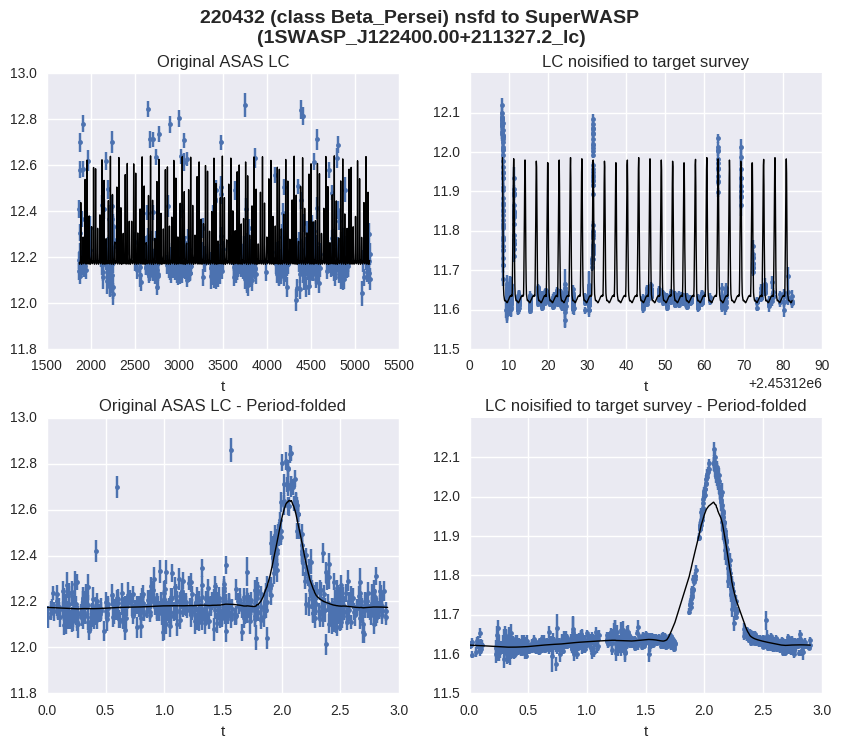

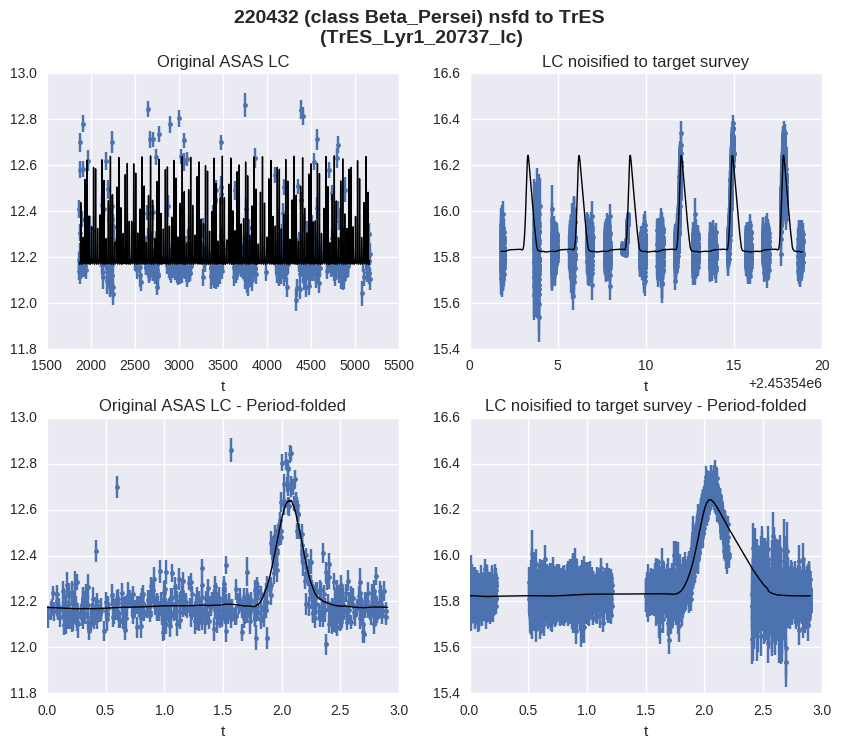

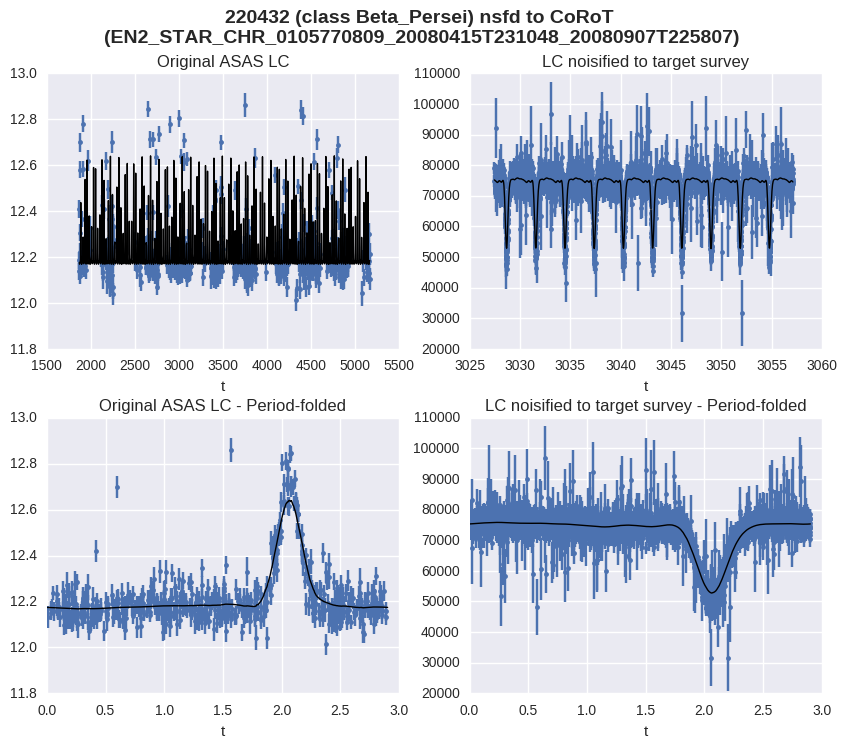

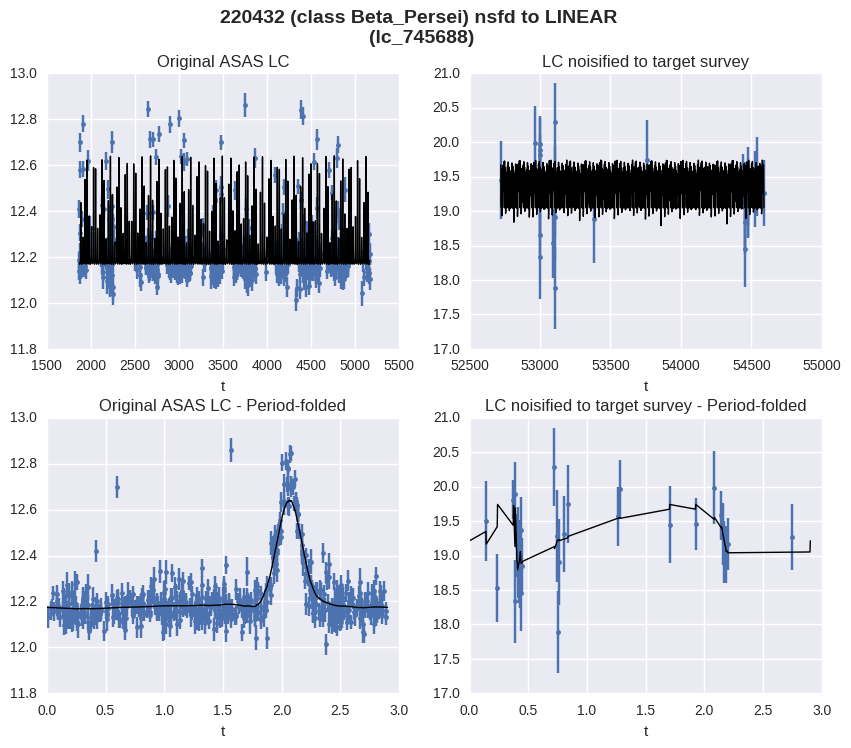

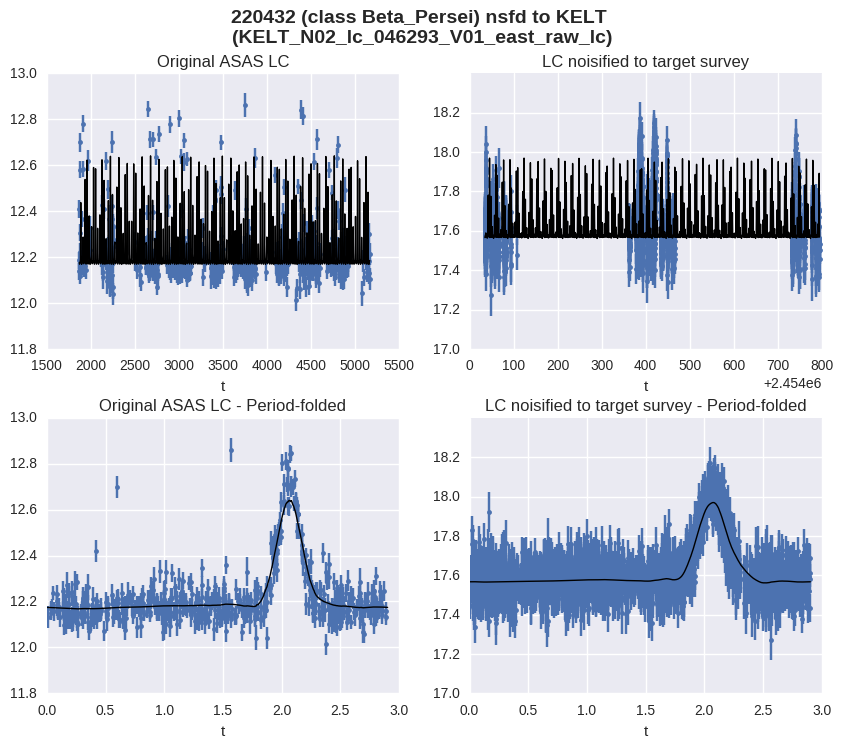

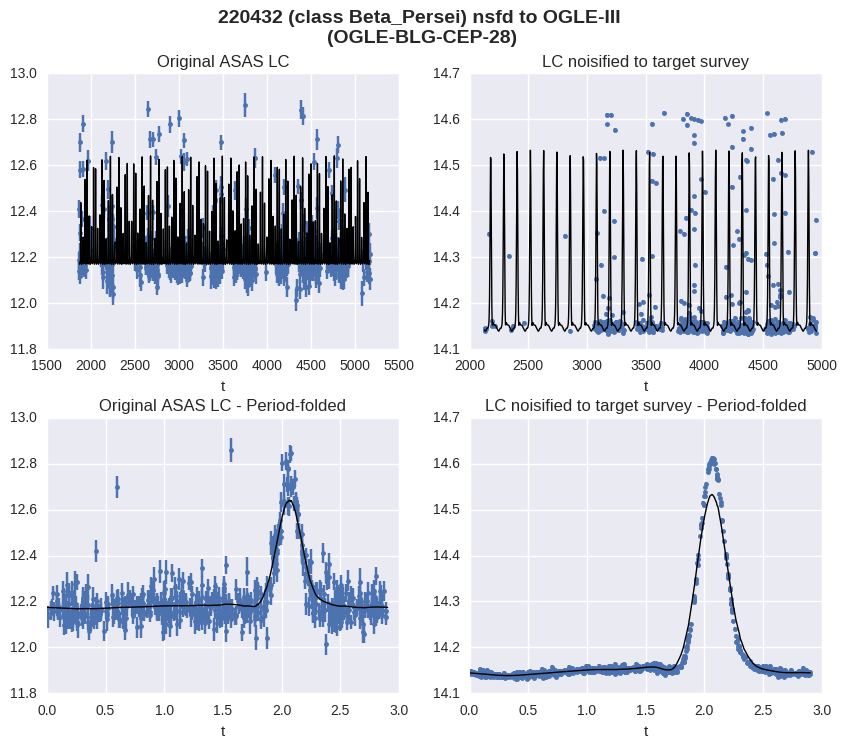

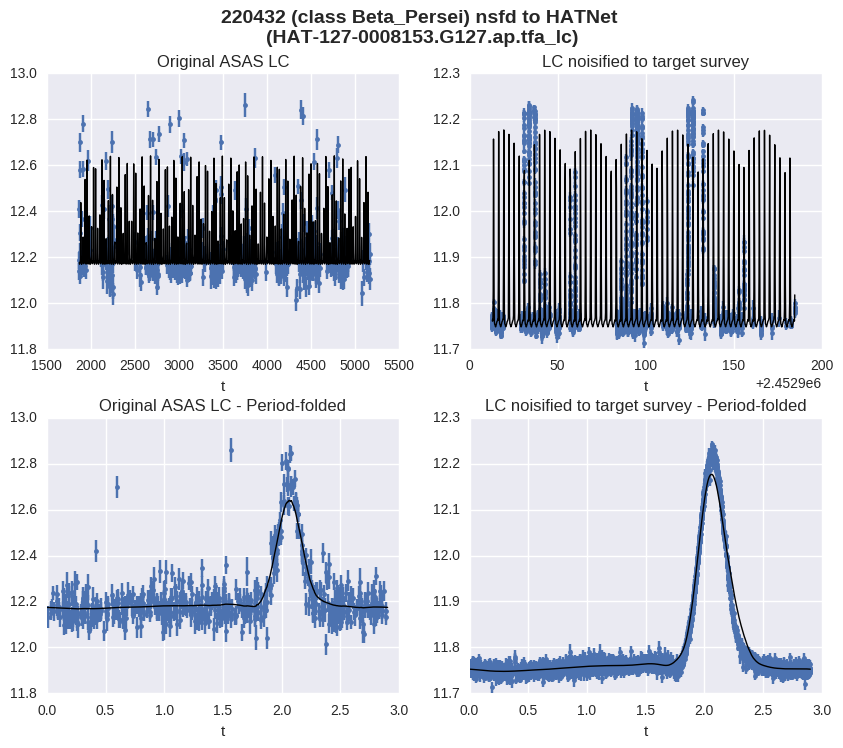

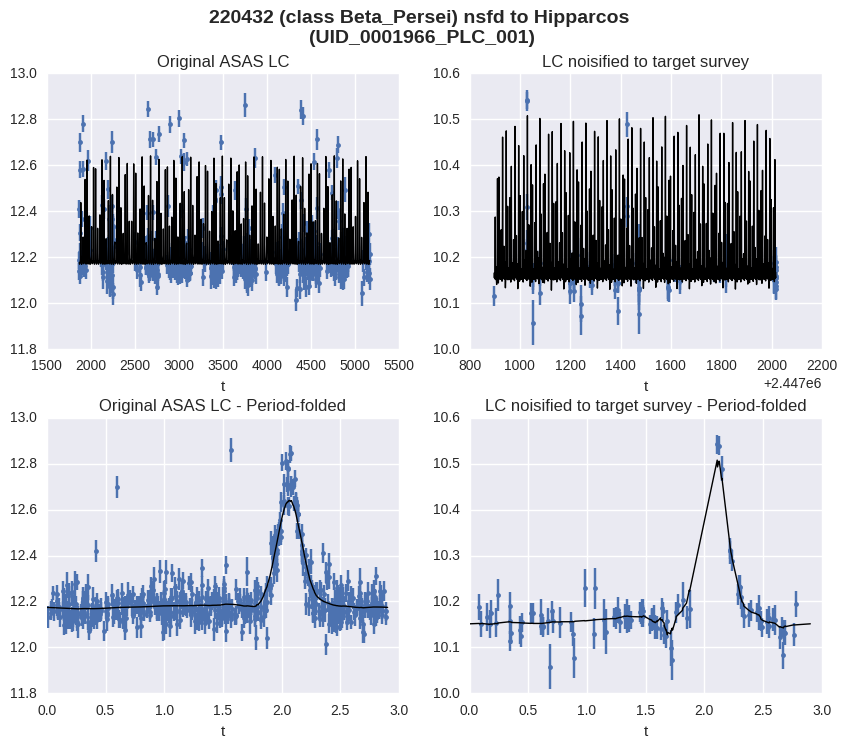

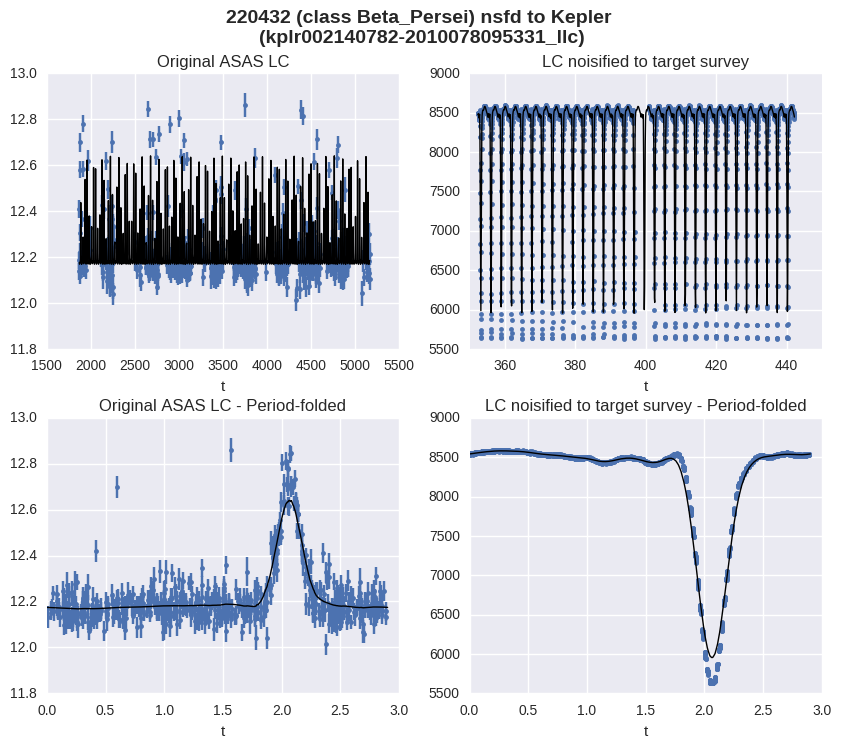

In [22]:
survey_to_noisified_fpaths = {}
# Smooth, noisify, & save LCs
for survey in survey_to_fpaths_dict:
    start_time = time.time()
    survey_to_noisified_fpaths[survey] = []
    
    # Get representative LC from this survey
    survey_df = survey_fs.where(survey_fs.target==survey, drop=True).to_dataframe().drop('target', 1)
    # Use top 17 most-important features only for finding representative LC
    survey_df = survey_df[['cad_probs_40', 'all_times_nhist_peak4_bin', 'cad_probs_500000', 'cad_probs_500', 
                           'all_times_nhist_peak_1_to_3', 'med_double_to_single_step', 'cad_probs_1000', 
                           'cad_probs_10000000', 'all_times_nhist_peak3_bin', 'cad_probs_100', 'cad_probs_5000000', 'cad_probs_1000000', 
                           'all_times_nhist_peak_2_to_4', 'avg_double_to_single_step', 
                           'all_times_nhist_peak_1_to_4', 'cad_probs_30', 'cad_probs_5000', 'n_epochs']]
    mean = survey_df.mean()
    tree = scipy.spatial.KDTree(survey_df.values)
    idx_closest = tree.query(mean)[1]
    prototype_fname = str(survey_fs.where(survey_fs.target==survey, drop=True).name[idx_closest].values)
    prototype_fpaths = [e for e in survey_to_fpaths_dict[survey] if 
                        os.path.basename(e).startswith(prototype_fname)]
    assert len(prototype_fpaths) == 1
    prototype_fpath = prototype_fpaths[0]
    print('\n\n', prototype_fpath)
    
    # Create target directory if it doesn't exist
    noisified_lcs_dir = 'data_no_dups/noisified_{}_lcs'.format(survey)
    if not os.path.exists(noisified_lcs_dir):
        os.mkdir(noisified_lcs_dir)
    
    # List of tuples to dump into headerfile
    fnames_targets = []
    
    seen_classes = defaultdict(int)

    # Smooth labeled ASAS LCs
    for idx, name in enumerate(asas_featureset.name.values):
        period = 1./asas_featureset.freq1_freq.sel(name=name).values[0]
        assert name in asas_ts_paths[idx]

        # Load TS data
        ts = cesium.time_series.from_netcdf(asas_ts_paths[idx])
        t, f, e = ts.time, ts.measurement, ts.error

        class_name = ts.target
        seen_classes[class_name] += 1
        plot_title = ('{} (class {}) nsfd to {} \n({})'.format(ts.name, class_name, survey, prototype_fname) 
                      if seen_classes[class_name] == 2 and class_name == 'Beta_Persei' else None)

        if seen_classes[class_name] != 2 or class_name != 'Beta_Persei':
            continue

        # Noisify each labeled ASAS LC to match prototype LC of target survey
        target_ts = cesium.time_series.from_netcdf(prototype_fpath)
        target_t, target_f, target_e = target_ts.time, target_ts.measurement, target_ts.error
        target_t, noisified_f, target_e = noisify_light_curve(t, f, e, period, 
                                                              target_t, target_f, target_e, plot_title)
        #print('target_t head and tail:', target_t[:5], target_t[-5:])
        # Create TimeSeries object and save as NetCDF
        new_ts = cesium.time_series.TimeSeries(
            t=target_t, m=noisified_f, e=target_e,
            target=str(asas_featureset.target.sel(name=name).values),
            name=name,
            path='{}/{}_nsfd_to_{}'.format(
                noisified_lcs_dir, name, os.path.basename(prototype_fpath)))
        # new_ts.to_netcdf()
        fnames_targets.append([os.path.basename(new_ts.path.replace('.nc', '')),
                               str(asas_featureset.target.sel(name=name).values)])
        survey_to_noisified_fpaths[survey].append(os.path.abspath(new_ts.path))
    # Write header file
    # pd.DataFrame(fnames_targets).to_csv('data_no_dups/{}_header.dat'.format(survey),
    #                                     index=False, header=False)
    # print('Noisified all ASAS LCs to prototype {} LC in {} minutes.\n\n'.format(survey, round((time.time() - start_time)/60., 2)))
#     # Tar noisified LCs
#     with tarfile.open('{}.tar.gz'.format(noisified_lcs_dir), 'w:gz') as tar:
#         tar.add(noisified_lcs_dir, arcname=os.path.basename(noisified_lcs_dir))

# Plot noisified W_Ursae_Maj LCs



 /home/arien/projects/survey_classifier/data_no_dups/1SWASP_J122400.00+211327.2_lc.nc
target_t head and tail: [ 2453128.383299  2453128.385602  2453128.387905] [ 2453202.387465  2453202.392211  2453202.396968]


 /home/arien/projects/survey_classifier/data_no_dups/TrES_Lyr1_20737_lc.nc
target_t head and tail: [ 2453541.787548  2453541.788878  2453541.790221] [ 2453558.90353   2453558.90445   2453558.904791]


 /home/arien/projects/survey_classifier/data_no_dups/EN2_STAR_CHR_0105770809_20080415T231048_20080907T225807.nc
target_t head and tail: [ 3027.46560088  3027.47152684  3027.47745279] [ 3057.10873075  3057.11465671  3057.12058267]


 /home/arien/projects/survey_classifier/data_no_dups/lc_745688.nc
target_t head and tail: [ 52722.2226388  52966.3578771  53002.3719415] [ 54526.265926   54537.2088874  54589.1457779]


 /home/arien/projects/survey_classifier/data_no_dups/KELT_N02_lc_046293_V01_east_raw_lc.nc
target_t head and tail: [ 2454034.702806  2454034.707429  2454034.712051] [ 

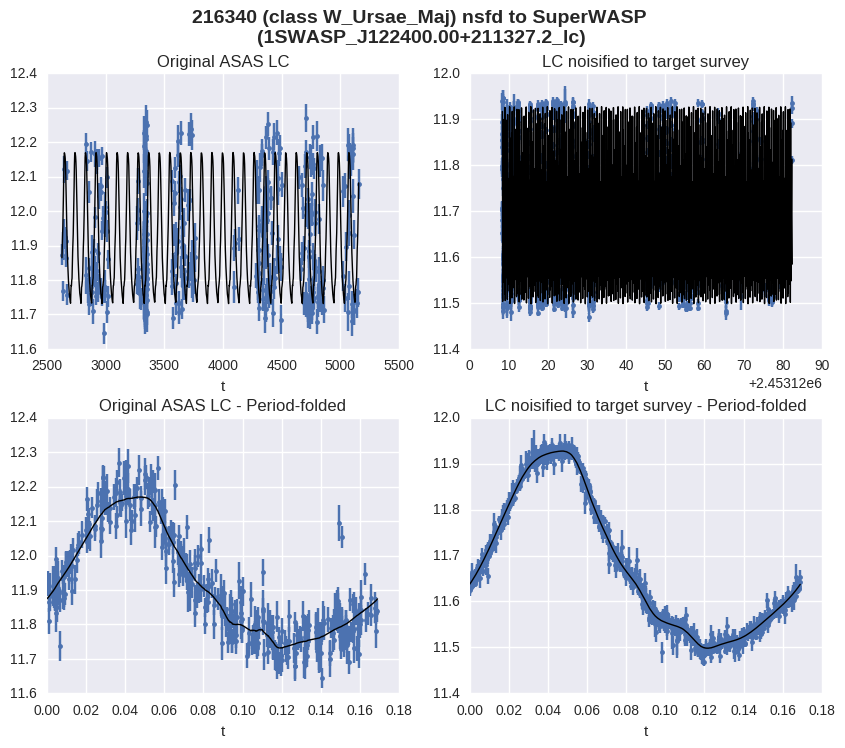

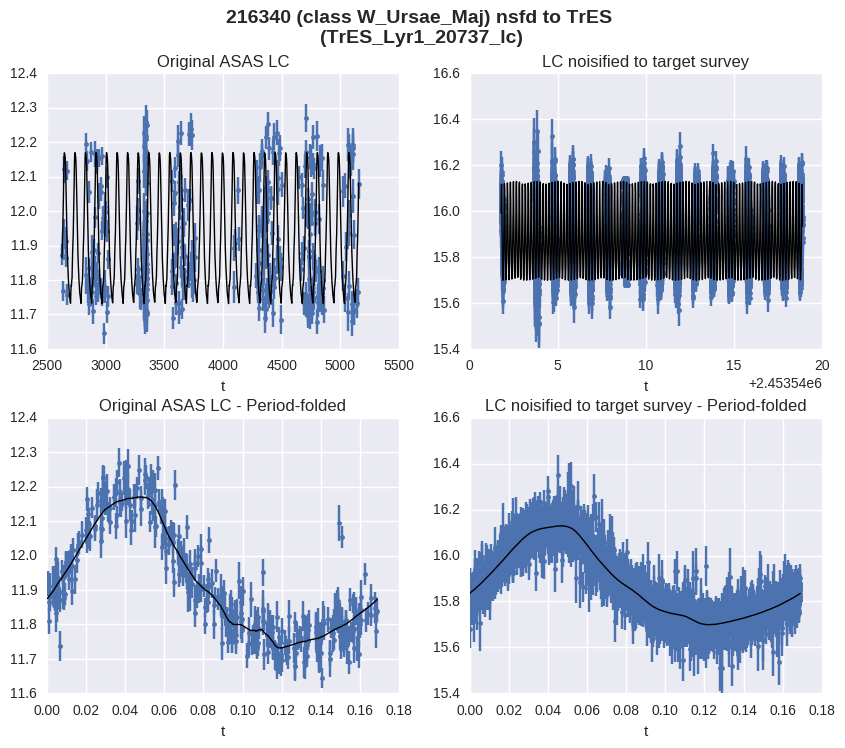

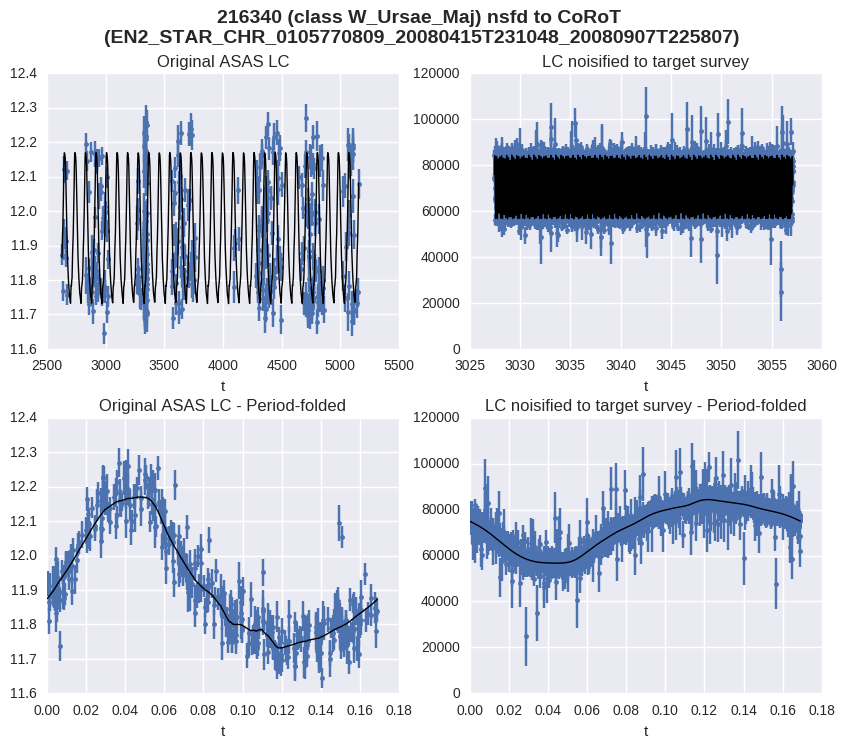

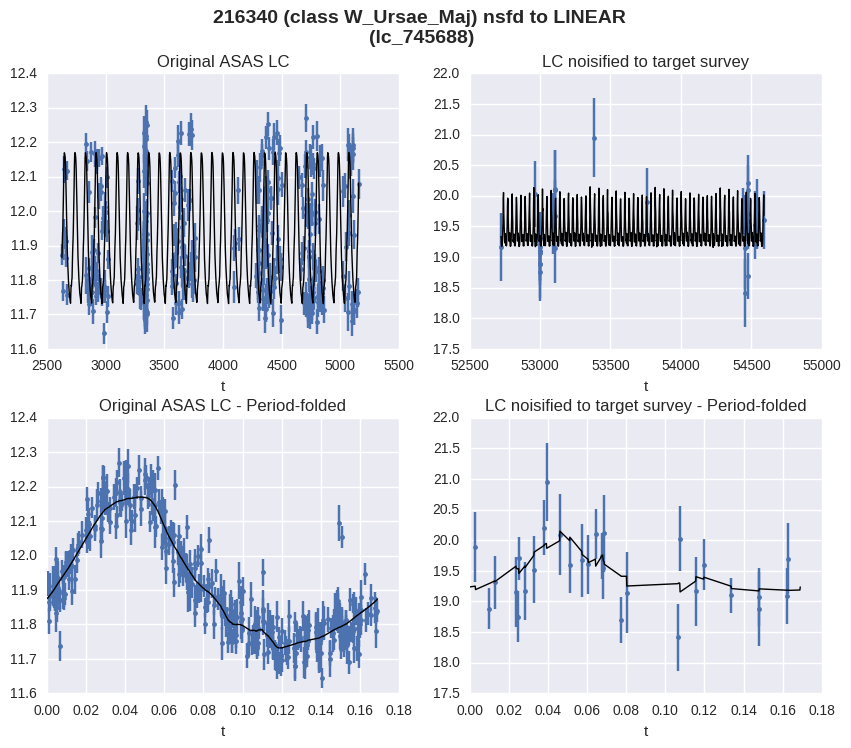

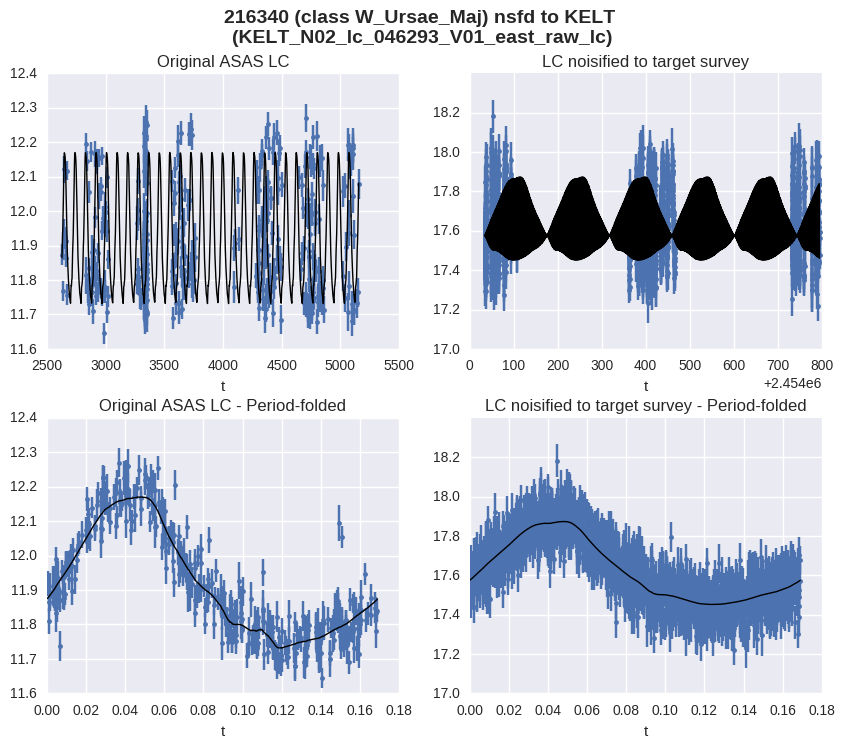

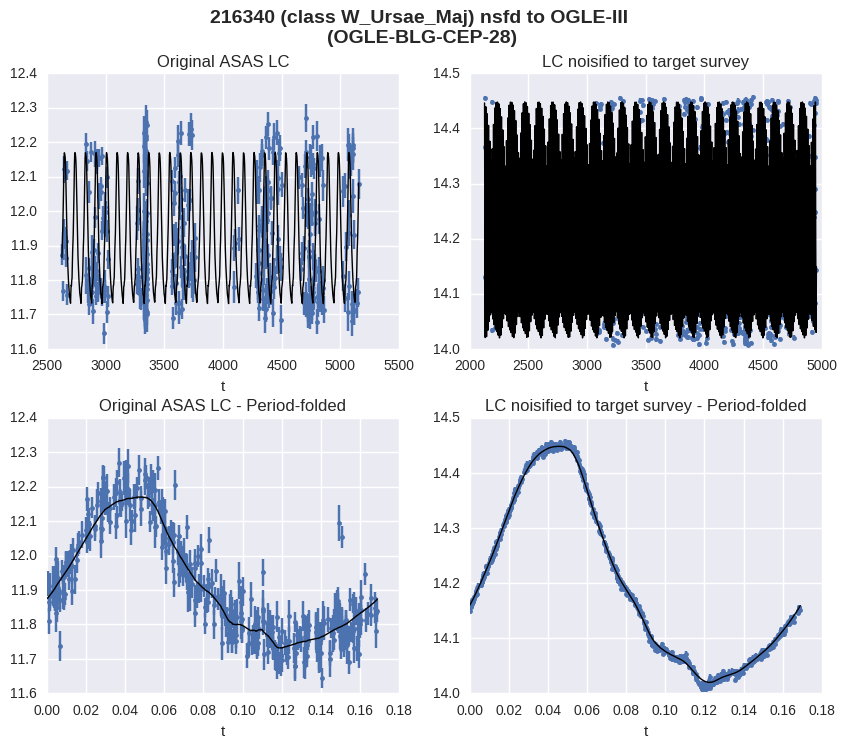

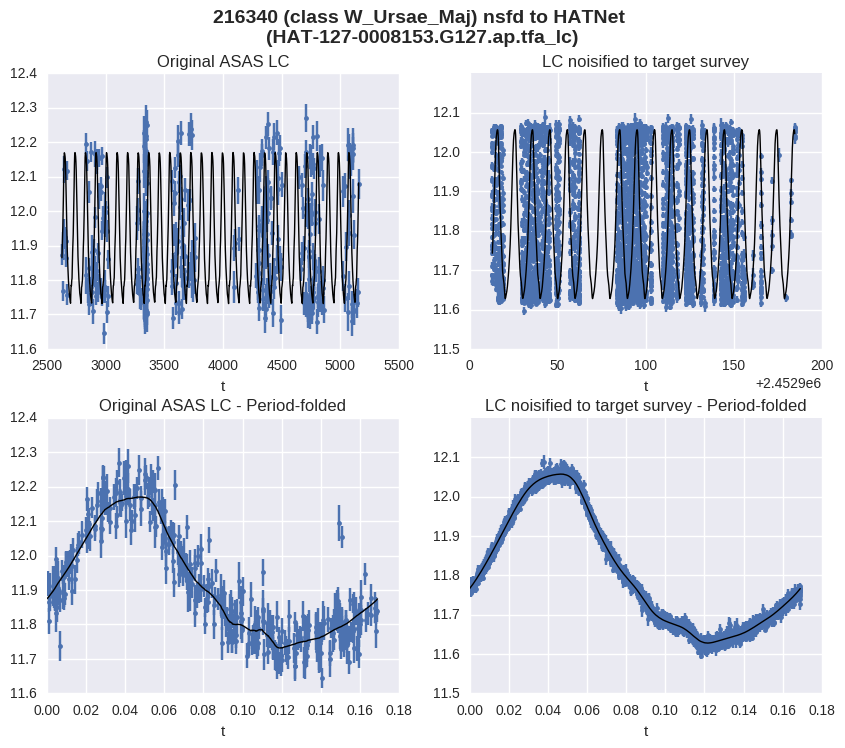

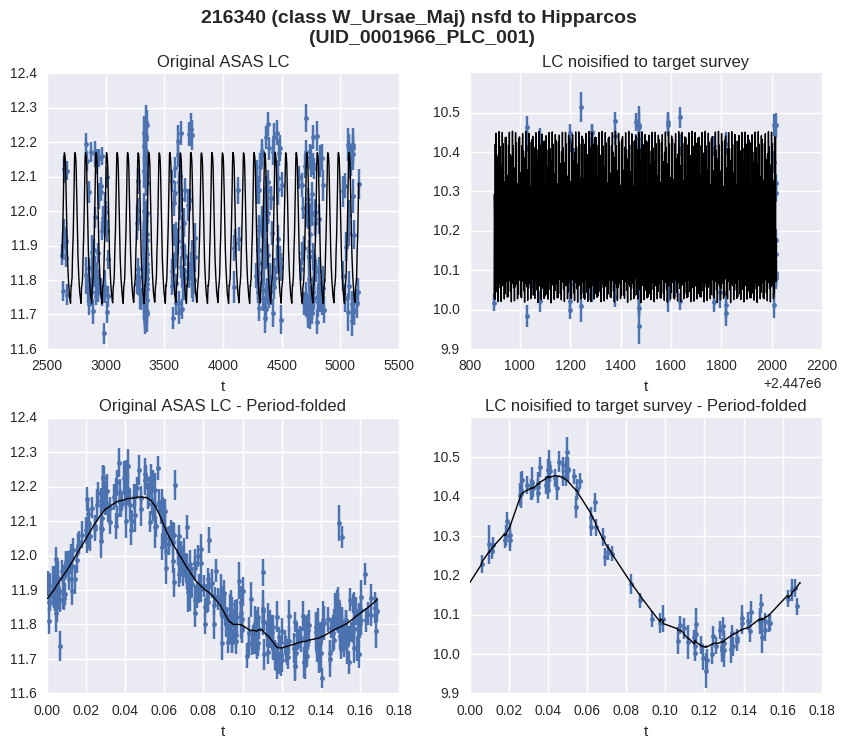

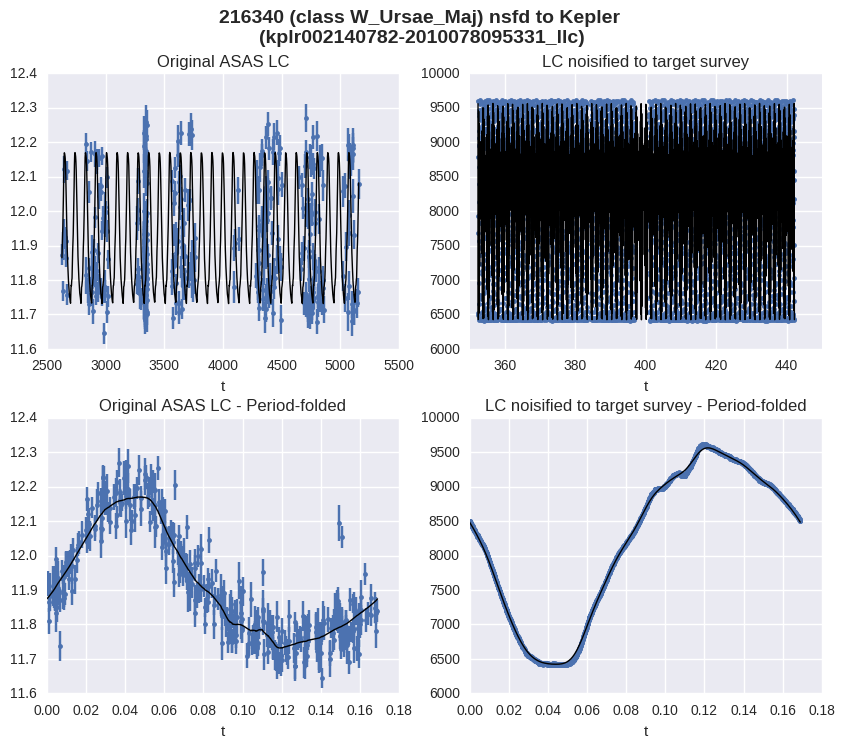

In [23]:
survey_to_noisified_fpaths = {}
# Smooth, noisify, & save LCs
for survey in survey_to_fpaths_dict:
    start_time = time.time()
    survey_to_noisified_fpaths[survey] = []
    
    # Get representative LC from this survey
    survey_df = survey_fs.where(survey_fs.target==survey, drop=True).to_dataframe().drop('target', 1)
    # Use top 17 most-important features only for finding representative LC
    survey_df = survey_df[['cad_probs_40', 'all_times_nhist_peak4_bin', 'cad_probs_500000', 'cad_probs_500', 
                           'all_times_nhist_peak_1_to_3', 'med_double_to_single_step', 'cad_probs_1000', 
                           'cad_probs_10000000', 'all_times_nhist_peak3_bin', 'cad_probs_100', 'cad_probs_5000000', 'cad_probs_1000000', 
                           'all_times_nhist_peak_2_to_4', 'avg_double_to_single_step', 
                           'all_times_nhist_peak_1_to_4', 'cad_probs_30', 'cad_probs_5000', 'n_epochs']]
    mean = survey_df.mean()
    tree = scipy.spatial.KDTree(survey_df.values)
    idx_closest = tree.query(mean)[1]
    prototype_fname = str(survey_fs.where(survey_fs.target==survey, drop=True).name[idx_closest].values)
    prototype_fpaths = [e for e in survey_to_fpaths_dict[survey] if 
                        os.path.basename(e).startswith(prototype_fname)]
    assert len(prototype_fpaths) == 1
    prototype_fpath = prototype_fpaths[0]
    print('\n\n', prototype_fpath)
    
    # Create target directory if it doesn't exist
    noisified_lcs_dir = 'data_no_dups/noisified_{}_lcs'.format(survey)
    if not os.path.exists(noisified_lcs_dir):
        os.mkdir(noisified_lcs_dir)
    
    # List of tuples to dump into headerfile
    fnames_targets = []
    
    seen_classes = defaultdict(int)

    # Smooth labeled ASAS LCs
    for idx, name in enumerate(asas_featureset.name.values):
        period = 1./asas_featureset.freq1_freq.sel(name=name).values[0]
        assert name in asas_ts_paths[idx]

        # Load TS data
        ts = cesium.time_series.from_netcdf(asas_ts_paths[idx])
        t, f, e = ts.time, ts.measurement, ts.error

        class_name = ts.target
        seen_classes[class_name] += 1
        plot_title = ('{} (class {}) nsfd to {} \n({})'.format(ts.name, class_name, survey, prototype_fname) 
                      if seen_classes[class_name] == 2 and class_name == 'W_Ursae_Maj' else None)

        if seen_classes[class_name] != 2 or class_name != 'W_Ursae_Maj':
            continue

        # Noisify each labeled ASAS LC to match prototype LC of target survey
        target_ts = cesium.time_series.from_netcdf(prototype_fpath)
        target_t, target_f, target_e = target_ts.time, target_ts.measurement, target_ts.error
        target_t, noisified_f, target_e = noisify_light_curve(t, f, e, period, 
                                                              target_t, target_f, target_e, plot_title)
        #print('target_t head and tail:', target_t[:5], target_t[-5:])
        # Create TimeSeries object and save as NetCDF
        new_ts = cesium.time_series.TimeSeries(
            t=target_t, m=noisified_f, e=target_e,
            target=str(asas_featureset.target.sel(name=name).values),
            name=name,
            path='{}/{}_nsfd_to_{}'.format(
                noisified_lcs_dir, name, os.path.basename(prototype_fpath)))
        # new_ts.to_netcdf()
        fnames_targets.append([os.path.basename(new_ts.path.replace('.nc', '')),
                               str(asas_featureset.target.sel(name=name).values)])
        survey_to_noisified_fpaths[survey].append(os.path.abspath(new_ts.path))
    # Write header file
    # pd.DataFrame(fnames_targets).to_csv('data_no_dups/{}_header.dat'.format(survey),
    #                                     index=False, header=False)
    # print('Noisified all ASAS LCs to prototype {} LC in {} minutes.\n\n'.format(survey, round((time.time() - start_time)/60., 2)))
#     # Tar noisified LCs
#     with tarfile.open('{}.tar.gz'.format(noisified_lcs_dir), 'w:gz') as tar:
#         tar.add(noisified_lcs_dir, arcname=os.path.basename(noisified_lcs_dir))

In [15]:
import glob

try:
    survey_to_noisified_fpaths
except NameError:
    survey_to_noisified_fpaths = {}

for survey in survey_to_fpaths_dict:
    if survey not in survey_to_noisified_fpaths:
        survey_to_noisified_fpaths[survey] = glob.glob('data_no_dups/noisified_{}_lcs/*.npz'.format(survey))
        
del survey_to_noisified_fpaths['ASAS']

# Generate cadence feats for noisified LCs

In [20]:
all_fpaths = []
all_labels = []
for survey in survey_to_noisified_fpaths:
    all_fpaths += survey_to_noisified_fpaths[survey]
    all_labels += [survey] * len(survey_to_noisified_fpaths[survey])

nsfd_survey_fset, _ = featurize.featurize_ts_files(all_fpaths, CADENCE_FEATS)

Exception ignored in: <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7f20743cfa90>>
Traceback (most recent call last):
  File "/home/arien/anaconda3/envs/survey_app2/lib/python3.6/site-packages/numpy/lib/npyio.py", line 208, in __del__
    self.close()
  File "/home/arien/anaconda3/envs/survey_app2/lib/python3.6/site-packages/numpy/lib/npyio.py", line 199, in close
    if self.zip is not None:
AttributeError: 'NpzFile' object has no attribute 'zip'
/home/arien/projects/cesium/cesium/features/cadence_features.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return (cads[2:] + cads[:-2]) / (cads[1:-1] - cads[:-2])
/home/arien/projects/cesium/cesium/features/cadence_features.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return (cads[2:] + cads[:-2]) / (cads[1:-1] - cads[:-2])
/home/arien/anaconda3/envs/survey_app2/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x =

## Compute survey classifier score for noisified LCs

In [22]:
nsfd_survey_fset = featurize.impute_featureset(nsfd_survey_fset)
survey_classifier = joblib.load('../../survey_classifier_data/data/survey_classifier.pkl')
preds = survey_classifier.predict(nsfd_survey_fset)
score = np.mean(preds == all_labels)
print(score)

1.0


# Generate science features for noisified datasets

In [16]:
feats_to_use = GENERAL_FEATS + LOMB_SCARGLE_FEATS

for survey in survey_to_noisified_fpaths:
    if survey in []:
        continue
    print('Generating features for {} LCs...'.format(survey))
    start_time = time.time()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        featureset, labels = featurize.featurize_ts_files(survey_to_noisified_fpaths[survey], feats_to_use)
    featureset = featurize.impute_featureset(featureset)
    featurize.save_featureset(featureset, 'data_no_dups/noisified_{}_features.npz'.format(survey), labels=labels)
    print('Featurization for {} completed in {} minutes.'.format(survey, round((time.time() - start_time)/60., 2)))

Generating features for CoRoT LCs...
Featurization for CoRoT completed in 21.86 minutes.
Generating features for HATNet LCs...
Featurization for HATNet completed in 14.13 minutes.
Generating features for Hipparcos LCs...
Featurization for Hipparcos completed in 3.18 minutes.
Generating features for KELT LCs...
Featurization for KELT completed in 11.53 minutes.
Generating features for Kepler LCs...
Featurization for Kepler completed in 17.0 minutes.
Generating features for LINEAR LCs...
Featurization for LINEAR completed in 4.04 minutes.
Generating features for OGLE-III LCs...
Featurization for OGLE-III completed in 11.82 minutes.
Generating features for SuperWASP LCs...
Featurization for SuperWASP completed in 0.46 minutes.
Generating features for TrES LCs...
Featurization for TrES completed in 24.03 minutes.


# Build models

In [17]:
for survey in survey_to_noisified_fpaths:
    if survey in []:
        continue
    featureset, data = featurize.load_featureset('data_no_dups/noisified_{}_features.npz'.format(survey))
    labels = data['labels']  # asas_fname_to_class_df.reindex(featureset.index).values
    
    print('\n\nBuilding model for {}...'.format(survey))
    start_time = time.time()
    model = RandomForestClassifier(n_estimators=1000)
    model.fit(featureset, labels)
#         params_to_optimize={'n_estimators': [250, 500, 1000],
#                             'max_features': [8, 10, 15, 18, 21],
#                             'min_samples_leaf': [1, 2, 5]})
    print('{} model built in {} minutes.'.format(survey, round((time.time() - start_time)/60., 2)))
#     print(model.best_params_)
    joblib.dump(model, 'data_no_dups/noisified_{}_model_compressed.pkl'.format(survey), 9)



Building model for CoRoT...
CoRoT model built in 0.07 minutes.


Building model for HATNet...
HATNet model built in 0.08 minutes.


Building model for Hipparcos...
Hipparcos model built in 0.08 minutes.


Building model for KELT...
KELT model built in 0.08 minutes.


Building model for Kepler...
Kepler model built in 0.07 minutes.


Building model for LINEAR...
LINEAR model built in 0.09 minutes.


Building model for OGLE-III...
OGLE-III model built in 0.08 minutes.


Building model for SuperWASP...
SuperWASP model built in 0.08 minutes.


Building model for TrES...
TrES model built in 0.08 minutes.


# Featurize original ASAS LCs & build model

In [18]:
# Featurize
print('Generating features for {} LCs...'.format('ASAS'))
feats_to_use = GENERAL_FEATS + LOMB_SCARGLE_FEATS
start_time = time.time()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    featureset, labels = featurize.featurize_ts_files(asas_ts_paths, feats_to_use)
featureset = featurize.impute_featureset(featureset)
featurize.save_featureset(featureset, 'data_no_dups/{}_features.npz'.format('ASAS'), labels=labels)
print('Featurization for {} completed in {} minutes.'.format('ASAS', round((time.time() - start_time)/60., 2)))

# labels = asas_fname_to_class_df.reindex(featureset.index).values

# Build model
print('\n\nBuilding model for {}...'.format('ASAS'))
start_time = time.time()
model = RandomForestClassifier(n_estimators=1000)
model.fit(featureset, labels)
#         params_to_optimize={'n_estimators': [250, 500, 1000],
#                             'max_features': [8, 10, 15, 18, 21],
#                             'min_samples_leaf': [1, 2, 5]})
print('{} model built in {} minutes.'.format('ASAS', round((time.time() - start_time)/60., 2)))
# print(model.best_params_)
joblib.dump(model, 'data_no_dups/ASAS_model_compressed.pkl', 9)

Generating features for ASAS LCs...
Featurization for ASAS completed in 10.76 minutes.


Building model for ASAS...
ASAS model built in 0.08 minutes.


['data_no_dups/ASAS_model_compressed.pkl']

# Compute train/test scores - NO DUPS

In [24]:
# Load ASAS fs
asas_fs, data = featurize.load_featureset('data_no_dups/ASAS_features.npz')
asas_fs_labels = data['labels']  # asas_fname_to_class_df.reindex(asas_fs.index)

# Drop all classes with fewer than 2 instances
MIN_EXAMPLES = 2
classes_to_drop = [label for label, count in asas_fname_to_class_df.target.value_counts().iteritems()
                   if count < MIN_EXAMPLES]
inds_to_drop = [i for i, t in enumerate(asas_fs_labels) if t in classes_to_drop]
asas_fs = asas_fs.drop(asas_fs.index.values[inds_to_drop])
asas_fs_labels = np.array([t for i, t in enumerate(asas_fs_labels) if t not in classes_to_drop])  # asas_fs_labels.drop(inds_to_drop)

# # Train/test split
train, test = train_test_split(np.arange(len(asas_fs_labels)), train_size=0.8, test_size=0.2,
                               stratify=asas_fs_labels, random_state=2)

# Build ASAS model
asas_model = RandomForestClassifier(n_estimators=1000)
asas_model.fit(asas_fs.iloc[train], asas_fs_labels[train])

# Predict
pred = asas_model.predict(asas_fs)
print('*' * 20, 'ASAS train score:', np.mean(pred[train] == asas_fs_labels[train]))
print('*' * 20, 'ASAS test score:', np.mean(pred[test] == asas_fs_labels[test]))
print('\n\n')

pct_improvement_list = []

# Now for the noisified data
for survey in survey_to_fpaths_dict:
    if survey in ['ASAS']:
        continue

    # Load noisified featureset
    fset, data = featurize.load_featureset('data_no_dups/noisified_{}_features.npz'.format(survey))
    inds_to_drop = [i for i, t in enumerate(data['labels']) if t in classes_to_drop]
    fset = fset.drop(fset.index.values[inds_to_drop])
    labels = np.array([t for i, t in enumerate(data['labels']) if t not in classes_to_drop])  # asas_fs_labels.reindex(fset.index).values.T[0].astype('str')
    
    # Train/test split
    train, test = train_test_split(np.arange(len(labels)), train_size=0.8, test_size=0.2,
                                   stratify=labels, random_state=2)

    # Build model
    model = RandomForestClassifier(n_estimators=1000)
    model.fit(fset.iloc[train], labels[train])
    
    # Save model
    joblib.dump(model, 'data_no_dups/noisified_{}_model_80t_compressed.pkl'.format(survey), 9)
    
    # Compute noisified model accuracy
    pred = model.predict(fset)
    train_score = np.mean(pred[train] == labels[train])
    test_score = np.mean(pred[test] == labels[test])
    print('*' * 20, 'noisified {} model train score:'.format(survey), train_score)
    print('*' * 20, 'noisified {} model test score:'.format(survey), test_score)
    
    # Compare with using regular ASAS model
    pred = asas_model.predict(fset)
    asas_model_train_score = np.mean(pred[train] == labels[train])
    asas_model_test_score = np.mean(pred[test] == labels[test])
    print('*' * 20, 'Noisified data with original ASAS model train score:'.format(survey), asas_model_train_score)
    print('*' * 20, 'Noisified data with original ASAS model test score:'.format(survey), asas_model_test_score)
    
    pct_improvement_list.append(((test_score - asas_model_test_score) / asas_model_test_score) * 100.0)
    print('*' * 25, round(pct_improvement_list[-1], 3), 
          'percent improvement over original ASAS model.', '\n\n')
    
    
print(np.mean(pct_improvement_list), "AVERAGE PERCENT IMPROVEMENT OVER NON-NOISIFIED MODEL (no dups)")

******************** ASAS train score: 1.0
******************** ASAS test score: 0.759259259259



******************** noisified CoRoT model train score: 1.0
******************** noisified CoRoT model test score: 0.672839506173
******************** Noisified data with original ASAS model train score: 0.11007751938
******************** Noisified data with original ASAS model test score: 0.104938271605
************************* 541.176 percent improvement over original ASAS model. 


******************** noisified HATNet model train score: 1.0
******************** noisified HATNet model test score: 0.716049382716
******************** Noisified data with original ASAS model train score: 0.531782945736
******************** Noisified data with original ASAS model test score: 0.543209876543
************************* 31.818 percent improvement over original ASAS model. 


******************** noisified Hipparcos model train score: 1.0
******************** noisified Hipparcos model test score

# Copy data to survey_classifier_data directory

In [30]:
# Copy original light curves
print('Copying original light curves from all surveys')
if not os.path.exists('../../survey_classifier_data/data/lightcurves'):
    os.mkdir(os.path.abspath('../../survey_classifier_data/data/lightcurves'))
for fpath in glob.glob('../../survey_classifier/data_no_dups/*.npz'):
    fpath = os.path.abspath(fpath)
    shutil.copy(fpath, os.path.join('../../survey_classifier_data/data/lightcurves', os.path.basename(fpath)))


# Copy original ASAS LCs, features, model
print('Copying ASAS data')
if not os.path.exists('../../survey_classifier_data/data/ASAS_lcs'):
    os.mkdir(os.path.abspath('../../survey_classifier_data/data/ASAS_lcs'))
# Copy orig LCs
for fpath in parse_ts_data_return_paths(tarball_path=asas_tarball_path, header_path=asas_header_path):
    fpath = os.path.abspath(fpath)
    shutil.copy(fpath, os.path.join('../../survey_classifier_data/data/ASAS_lcs/', os.path.basename(fpath)))
# Copy featureset and model
shutil.copy('data_no_dups/ASAS_features.npz', '../../survey_classifier_data/data/ASAS_features.npz')
shutil.copy('data_no_dups/ASAS_model_compressed.pkl', '../../survey_classifier_data/data/ASAS_model_compressed.pkl')


# Copy light curves, features and models for each of the target surveys
for survey in survey_to_fpaths_dict:
    if survey in ['ASAS']:
        continue
    print('Copying {} data.'.format(survey))
    # Copy noisified light curves
    if not os.path.exists('../../survey_classifier_data/data/_noisified_{}_lcs'.format(survey)):
        os.mkdir('../../survey_classifier_data/data/noisified_{}_lcs'.format(survey))
    for fpath in glob.glob('data_no_dups/noisified_{}_lcs/*.npz'.format(survey)):
        shutil.copy(fpath, os.path.join('../../survey_classifier_data/data/_noisified_{}_lcs'.format(survey),
                                        os.path.basename(fpath)))
    # Copy featuresets
    shutil.copy('data_no_dups/noisified_{}_features.npz'.format(survey), 
                '../../survey_classifier_data/data/noisified_{}_features.npz'.format(survey))
    # Copy models
    shutil.copy('data_no_dups/noisified_{}_model_compressed.pkl'.format(survey), 
                '../../survey_classifier_data/data/noisified_{}_model_compressed.pkl'.format(survey))


# Copy survey classifier features & model
shutil.copy('../../survey_classifier/data_no_dups/survey_lc_features.npz',
            '../../survey_classifier_data/data/survey_lc_features.npz')
shutil.copy('../../survey_classifier/data_no_dups/survey_classifier_no_dups.pkl',
            '../../survey_classifier_data/data/survey_classifier.pkl')

print('Done.')

Copying original light curves from all surveys
Copying ASAS data
Parsed & stored 810 light curves in 0.1 minutes
Copying CoRoT data.
Copying HATNet data.
Copying Hipparcos data.
Copying KELT data.
Copying Kepler data.
Copying LINEAR data.
Copying OGLE-III data.
Copying SuperWASP data.
Copying TrES data.
Done.
